In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker #For changing ticker location and formatting
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [2]:
df = pd.read_csv('./datasets/clean_recoded_ames.csv')
df.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,mo_sold,yr_sold,sale_type,saleprice,age_at_sale,age_since_remod,bsmnt_fin_sf,sold_in_crisis,has_wood_deck,has_pool
0,109,533352170,60,RL,0.0,13517,Pave,NaN,3,Lvl,...,3,2010,WD,130500,34,5,533.0,1,0,0
1,544,531379050,60,RL,43.0,11492,Pave,NaN,3,Lvl,...,4,2009,WD,220000,13,12,637.0,1,0,0
2,153,535304180,20,RL,68.0,7922,Pave,NaN,4,Lvl,...,1,2010,WD,109000,57,3,731.0,1,0,0
3,318,916386060,60,RL,73.0,9802,Pave,NaN,4,Lvl,...,4,2010,WD,174000,4,3,0.0,1,1,0
4,255,906425045,50,RL,82.0,14235,Pave,NaN,3,Lvl,...,3,2010,WD,138500,110,17,0.0,1,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049 entries, 0 to 2048
Data columns (total 87 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2049 non-null   int64  
 1   pid              2049 non-null   int64  
 2   ms_subclass      2049 non-null   int64  
 3   ms_zoning        2049 non-null   object 
 4   lot_frontage     2049 non-null   float64
 5   lot_area         2049 non-null   int64  
 6   street           2049 non-null   object 
 7   alley            140 non-null    object 
 8   lot_shape        2049 non-null   int64  
 9   land_contour     2049 non-null   object 
 10  utilities        2049 non-null   object 
 11  lot_config       2049 non-null   object 
 12  land_slope       2049 non-null   int64  
 13  neighborhood     2049 non-null   object 
 14  condition_1      2049 non-null   object 
 15  condition_2      2049 non-null   object 
 16  bldg_type        2049 non-null   object 
 17  house_style   

##### Was exporting mo_sold as a string, but importing as an object so recalling it a string. Same with Garage Type - nulls should be filled in on last data set.

In [4]:
df['mo_sold'] = df['mo_sold'].astype(str)

In [5]:
df['garage_type'].fillna('None', inplace = True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049 entries, 0 to 2048
Data columns (total 87 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2049 non-null   int64  
 1   pid              2049 non-null   int64  
 2   ms_subclass      2049 non-null   int64  
 3   ms_zoning        2049 non-null   object 
 4   lot_frontage     2049 non-null   float64
 5   lot_area         2049 non-null   int64  
 6   street           2049 non-null   object 
 7   alley            140 non-null    object 
 8   lot_shape        2049 non-null   int64  
 9   land_contour     2049 non-null   object 
 10  utilities        2049 non-null   object 
 11  lot_config       2049 non-null   object 
 12  land_slope       2049 non-null   int64  
 13  neighborhood     2049 non-null   object 
 14  condition_1      2049 non-null   object 
 15  condition_2      2049 non-null   object 
 16  bldg_type        2049 non-null   object 
 17  house_style   

In [7]:
null_model = df['saleprice'].mean()
null_model

181479.01805758907

In [136]:
#Residuals for Null model - 
resdiuals = null_model - df['saleprice']
resdiuals

#SSE
(resdiuals ** 2).sum()

#MSE
( (resdiuals ** 2).sum() ) / len(resdiuals)

#RMSE
( ( (resdiuals ** 2).sum() ) / len(resdiuals) ) ** 0.5

#metrics.mean_squared_error(df['saleprice'], null_model, squared = False)

79276.56098763691

#### Identify which variables correlate with sale price to help with feature selection

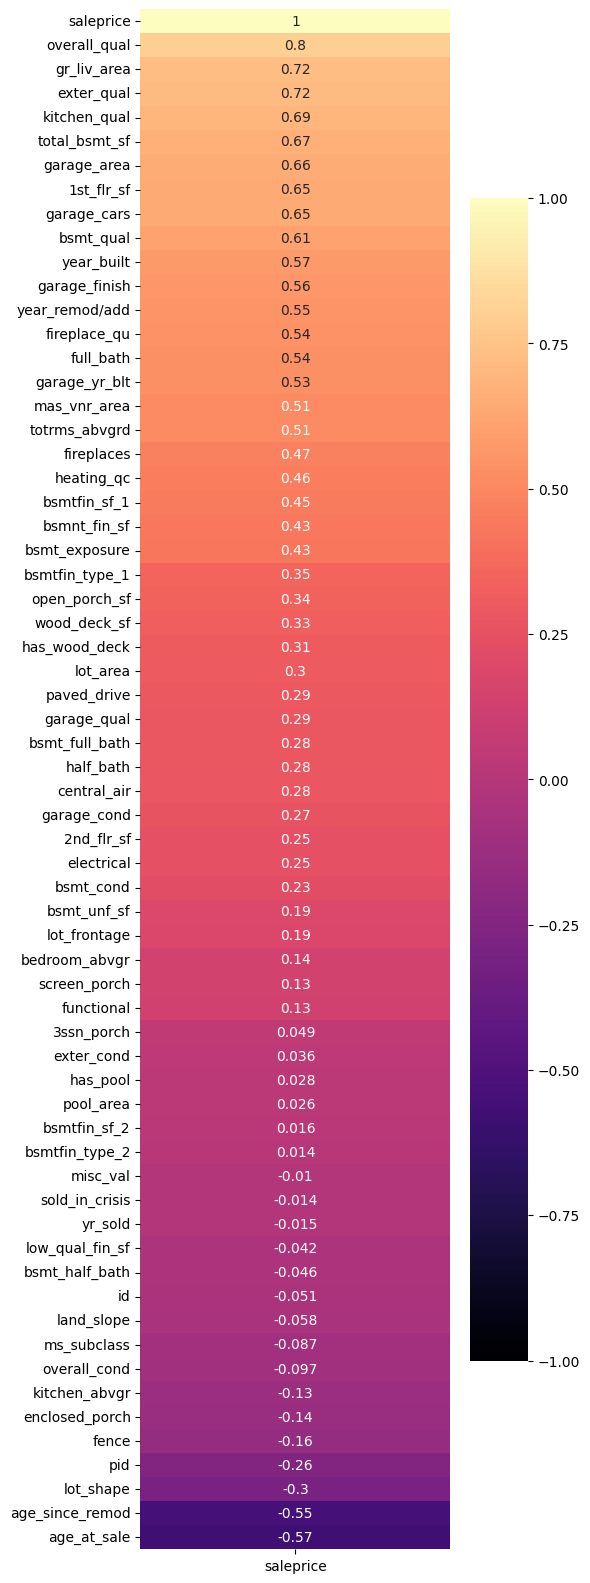

In [8]:
plt.figure(figsize = (5,20))

sns.heatmap(df.corr(numeric_only = True) 
            [['saleprice']].sort_values(by = 'saleprice', ascending = False),
            vmin = -1, vmax = 1,
            annot = True, cmap = 'magma');

In [9]:
#The correlation values for saleprice
correlation_values = df.corr(numeric_only = True)[['saleprice']]
correlation_values.sort_values('saleprice')

,saleprice
age_at_sale,-0.572441
age_since_remod,-0.552226
lot_shape,-0.296743
pid,-0.255068
fence,-0.159136
...,...
kitchen_qual,0.694295
exter_qual,0.715048
gr_liv_area,0.719463
overall_qual,0.803462


In [10]:
#Selecting just those where the correlation is above 0.3 or below 0.3
numeric_cols_corr_above_abs_3 = correlation_values[ (correlation_values['saleprice'] > 0.3 ) | (correlation_values['saleprice'] < -0.3 ) ]
print(type(numeric_cols_corr_above_abs_3))
numeric_cols_corr_above_abs_3.sort_values('saleprice')

<class 'pandas.core.frame.DataFrame'>


,saleprice
age_at_sale,-0.572441
age_since_remod,-0.552226
lot_area,0.303744
has_wood_deck,0.311534
wood_deck_sf,0.327629
open_porch_sf,0.338545
bsmtfin_type_1,0.350728
bsmt_exposure,0.426134
bsmnt_fin_sf,0.430531
bsmtfin_sf_1,0.446103


In [11]:
numeric_cols = numeric_cols_corr_above_abs_3.index.tolist()
print(type(numeric_cols))
numeric_cols

<class 'list'>


['lot_area',
 'overall_qual',
 'year_built',
 'year_remod/add',
 'mas_vnr_area',
 'exter_qual',
 'bsmt_qual',
 'bsmt_exposure',
 'bsmtfin_type_1',
 'bsmtfin_sf_1',
 'total_bsmt_sf',
 'heating_qc',
 '1st_flr_sf',
 'gr_liv_area',
 'full_bath',
 'kitchen_qual',
 'totrms_abvgrd',
 'fireplaces',
 'fireplace_qu',
 'garage_yr_blt',
 'garage_finish',
 'garage_cars',
 'garage_area',
 'wood_deck_sf',
 'open_porch_sf',
 'saleprice',
 'age_at_sale',
 'age_since_remod',
 'bsmnt_fin_sf',
 'has_wood_deck']

In [12]:
numeric_cols_to_remove = ['saleprice', 'garage_yr_blt', 'year_built', 'year_remod/add']
    # Removing Garage Yr Built since it has nulls, and year_built, year_remod/add since better coded as age
filtered_numeric_cols = [feature for feature in numeric_cols if feature not in numeric_cols_to_remove]
filtered_numeric_cols

['lot_area',
 'overall_qual',
 'mas_vnr_area',
 'exter_qual',
 'bsmt_qual',
 'bsmt_exposure',
 'bsmtfin_type_1',
 'bsmtfin_sf_1',
 'total_bsmt_sf',
 'heating_qc',
 '1st_flr_sf',
 'gr_liv_area',
 'full_bath',
 'kitchen_qual',
 'totrms_abvgrd',
 'fireplaces',
 'fireplace_qu',
 'garage_finish',
 'garage_cars',
 'garage_area',
 'wood_deck_sf',
 'open_porch_sf',
 'age_at_sale',
 'age_since_remod',
 'bsmnt_fin_sf',
 'has_wood_deck']

#### Model based on all numeric values

In [278]:
numeric_data = df.select_dtypes(exclude = 'object')
numeric_data.head(5)

,id,pid,ms_subclass,lot_frontage,lot_area,lot_shape,land_slope,overall_qual,overall_cond,year_built,...,fence,misc_val,yr_sold,saleprice,age_at_sale,age_since_remod,bsmnt_fin_sf,sold_in_crisis,has_wood_deck,has_pool
0,109,533352170,60,0.0,13517,3,3,6,8,1976,...,0,0,2010,130500,34,5,533.0,1,0,0
1,544,531379050,60,43.0,11492,3,3,7,5,1996,...,0,0,2009,220000,13,12,637.0,1,0,0
2,153,535304180,20,68.0,7922,4,3,5,7,1953,...,0,0,2010,109000,57,3,731.0,1,0,0
3,318,916386060,60,73.0,9802,4,3,5,5,2006,...,0,0,2010,174000,4,3,0.0,1,1,0
4,255,906425045,50,82.0,14235,3,3,6,8,1900,...,0,0,2010,138500,110,17,0.0,1,0,0


In [277]:
numeric_data.dtypes

id                   int64
pid                  int64
ms_subclass          int64
lot_frontage       float64
lot_area             int64
lot_shape            int64
land_slope           int64
overall_qual         int64
overall_cond         int64
year_built           int64
year_remod/add       int64
mas_vnr_area       float64
exter_qual           int64
exter_cond           int64
bsmt_qual            int64
bsmt_cond            int64
bsmt_exposure        int64
bsmtfin_type_1       int64
bsmtfin_sf_1       float64
bsmtfin_type_2       int64
bsmtfin_sf_2       float64
bsmt_unf_sf        float64
total_bsmt_sf      float64
heating_qc           int64
central_air          int64
electrical           int64
1st_flr_sf           int64
2nd_flr_sf           int64
low_qual_fin_sf      int64
gr_liv_area          int64
bsmt_full_bath     float64
bsmt_half_bath     float64
full_bath            int64
half_bath            int64
bedroom_abvgr        int64
kitchen_abvgr        int64
kitchen_qual         int64
t

In [224]:
numeric_data_cols = numeric_data.columns.tolist()
numeric_data_cols

['id',
 'pid',
 'ms_subclass',
 'lot_frontage',
 'lot_area',
 'lot_shape',
 'land_slope',
 'overall_qual',
 'overall_cond',
 'year_built',
 'year_remod/add',
 'mas_vnr_area',
 'exter_qual',
 'exter_cond',
 'bsmt_qual',
 'bsmt_cond',
 'bsmt_exposure',
 'bsmtfin_type_1',
 'bsmtfin_sf_1',
 'bsmtfin_type_2',
 'bsmtfin_sf_2',
 'bsmt_unf_sf',
 'total_bsmt_sf',
 'heating_qc',
 'central_air',
 'electrical',
 '1st_flr_sf',
 '2nd_flr_sf',
 'low_qual_fin_sf',
 'gr_liv_area',
 'bsmt_full_bath',
 'bsmt_half_bath',
 'full_bath',
 'half_bath',
 'bedroom_abvgr',
 'kitchen_abvgr',
 'kitchen_qual',
 'totrms_abvgrd',
 'functional',
 'fireplaces',
 'fireplace_qu',
 'garage_yr_blt',
 'garage_finish',
 'garage_cars',
 'garage_area',
 'garage_qual',
 'garage_cond',
 'paved_drive',
 'wood_deck_sf',
 'open_porch_sf',
 'enclosed_porch',
 '3ssn_porch',
 'screen_porch',
 'pool_area',
 'fence',
 'misc_val',
 'yr_sold',
 'saleprice',
 'age_at_sale',
 'age_since_remod',
 'bsmnt_fin_sf',
 'sold_in_crisis',
 'has_wood

In [161]:
numeric_data.isnull().sum()

id                   0
pid                  0
ms_subclass          0
lot_frontage         0
lot_area             0
lot_shape            0
land_slope           0
overall_qual         0
overall_cond         0
year_built           0
year_remod/add       0
mas_vnr_area         0
exter_qual           0
exter_cond           0
bsmt_qual            0
bsmt_cond            0
bsmt_exposure        0
bsmtfin_type_1       0
bsmtfin_sf_1         0
bsmtfin_type_2       0
bsmtfin_sf_2         0
bsmt_unf_sf          0
total_bsmt_sf        0
heating_qc           0
central_air          0
electrical           0
1st_flr_sf           0
2nd_flr_sf           0
low_qual_fin_sf      0
gr_liv_area          0
bsmt_full_bath       0
bsmt_half_bath       0
full_bath            0
half_bath            0
bedroom_abvgr        0
kitchen_abvgr        0
kitchen_qual         0
totrms_abvgrd        0
functional           0
fireplaces           0
fireplace_qu         0
garage_yr_blt      114
garage_finish        0
garage_cars

In [174]:
cols_to_drop = ['id', 'pid', 'saleprice', 'garage_yr_blt'] #Drop unique IDs, sale price, and garage_yr_blt since it has nulls
X_numeric = numeric_data.drop(cols_to_drop, axis = 1)
y_numeric = df['saleprice']

In [279]:
X_numeric.head()

,ms_subclass,lot_frontage,lot_area,lot_shape,land_slope,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,...,pool_area,fence,misc_val,yr_sold,age_at_sale,age_since_remod,bsmnt_fin_sf,sold_in_crisis,has_wood_deck,has_pool
0,60,0.0,13517,3,3,6,8,1976,2005,289.0,...,0,0,0,2010,34,5,533.0,1,0,0
1,60,43.0,11492,3,3,7,5,1996,1997,132.0,...,0,0,0,2009,13,12,637.0,1,0,0
2,20,68.0,7922,4,3,5,7,1953,2007,0.0,...,0,0,0,2010,57,3,731.0,1,0,0
3,60,73.0,9802,4,3,5,5,2006,2007,0.0,...,0,0,0,2010,4,3,0.0,1,1,0
4,50,82.0,14235,3,3,6,8,1900,1993,0.0,...,0,0,0,2010,110,17,0.0,1,0,0


In [276]:
cols_in_final_model = X_numeric.columns.tolist()
print(type(cols_in_final_model))
cols_in_final_model

<class 'list'>


['ms_subclass',
 'lot_frontage',
 'lot_area',
 'lot_shape',
 'land_slope',
 'overall_qual',
 'overall_cond',
 'year_built',
 'year_remod/add',
 'mas_vnr_area',
 'exter_qual',
 'exter_cond',
 'bsmt_qual',
 'bsmt_cond',
 'bsmt_exposure',
 'bsmtfin_type_1',
 'bsmtfin_sf_1',
 'bsmtfin_type_2',
 'bsmtfin_sf_2',
 'bsmt_unf_sf',
 'total_bsmt_sf',
 'heating_qc',
 'central_air',
 'electrical',
 '1st_flr_sf',
 '2nd_flr_sf',
 'low_qual_fin_sf',
 'gr_liv_area',
 'bsmt_full_bath',
 'bsmt_half_bath',
 'full_bath',
 'half_bath',
 'bedroom_abvgr',
 'kitchen_abvgr',
 'kitchen_qual',
 'totrms_abvgrd',
 'functional',
 'fireplaces',
 'fireplace_qu',
 'garage_finish',
 'garage_cars',
 'garage_area',
 'garage_qual',
 'garage_cond',
 'paved_drive',
 'wood_deck_sf',
 'open_porch_sf',
 'enclosed_porch',
 '3ssn_porch',
 'screen_porch',
 'pool_area',
 'fence',
 'misc_val',
 'yr_sold',
 'age_at_sale',
 'age_since_remod',
 'bsmnt_fin_sf',
 'sold_in_crisis',
 'has_wood_deck',
 'has_pool']

In [175]:
X_numeric.shape, y_numeric.shape

((2049, 60), (2049,))

In [176]:
X_numeric_train, X_numeric_test, y_numeric_train, y_numeric_test = train_test_split(X_numeric, y_numeric)

In [177]:
X_numeric_train.shape, X_numeric_test.shape, y_numeric_train.shape, y_numeric_test.shape

((1536, 60), (513, 60), (1536,), (513,))

In [178]:
lr_numeric = LinearRegression()

In [179]:
lr_numeric.fit(X_numeric_train, y_numeric_train)

LinearRegression()

In [180]:
lr_numeric.score(X_numeric_train, y_numeric_train)

0.8992890547551239

In [181]:
lr_numeric.score(X_numeric_test, y_numeric_test)

0.8825179413484368

In [182]:
cross_val_score(lr_numeric, X_numeric_train, y_numeric_train).mean()

0.8842789024899107

In [184]:
y_numeric_preds = lr_numeric.predict(X_numeric_test)
    #This is what I'll assign to the Kaggle test score

rmse = metrics.mean_squared_error(y_numeric_test, y_numeric_preds, squared = False)
rmse

24890.422188040313

In [281]:
lr_numeric.coef_

array([-1.07123399e+02,  9.16382708e+01,  6.51793747e-01, -5.37005074e+02,
        8.45867575e+02,  9.85353837e+03,  5.41337903e+03,  1.22010232e+02,
        6.22209182e+00,  3.44939188e+01,  1.26276323e+04, -1.21999575e+03,
        7.42603325e+03, -1.33329110e+04,  4.49159906e+03, -1.14252900e+03,
        1.70072571e+01,  1.14490058e+03, -4.72488515e+00,  5.10858285e+00,
        1.73909548e+01,  7.83374909e+02, -6.13627084e+03, -6.38119117e+02,
        2.03649732e+01,  1.97567843e+01, -6.89354026e+00,  3.32282173e+01,
        2.05779701e+03, -5.61266745e+03,  5.50476043e+02,  1.80916323e+03,
       -5.95971848e+03, -1.53336473e+04,  1.04224041e+04,  2.94738348e+03,
        5.52801735e+03,  1.00160538e+03,  1.77696888e+03, -3.92323348e+02,
       -9.81718914e+02,  2.89360897e+01,  2.98728183e+03, -7.40289858e+03,
        3.08142425e+02,  2.65961880e+01, -7.68444000e+00,  5.15432798e+00,
       -2.72204490e+01,  3.80673293e+01, -5.86501948e+01, -7.25897050e+02,
       -8.98164738e-02,  

In [283]:
pd.DataFrame(data = lr_numeric.coef_,
             index = X_numeric.columns,
             columns = ['Coefficients']).sort_values(by = 'Coefficients', ascending = False)

,Coefficients
has_pool,"27,950.6"
exter_qual,"12,627.6"
kitchen_qual,"10,422.4"
overall_qual,"9,853.5"
bsmt_qual,"7,426.0"
functional,"5,528.0"
overall_cond,"5,413.4"
bsmt_exposure,"4,491.6"
garage_qual,"2,987.3"
totrms_abvgrd,"2,947.4"


In [285]:
model_coefs = pd.DataFrame(data = lr_numeric.coef_,
             index = X_numeric.columns,
             columns = ['Coefficients']).sort_values(by = 'Coefficients', ascending = False)

In [286]:
type(model_coefs)

pandas.core.frame.DataFrame

In [287]:
model_coefs.to_csv('./datasets/model_coefs.csv')

## All things being equal, selling your house during the Great Recession (2008 - 2010) reduced the Ames home value by $2,069.30

## Model based on just numeirc values where correlation is above abs(0.3)

In [148]:
X = df[filtered_numeric_cols]
y = df['saleprice']

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [154]:
lr.score(X_train, y_train)

0.8803167823609737

In [17]:
lr.score(X_test, y_test)

0.8665442254785292

In [18]:
cross_val_score(lr, X_train, y_train).mean()

0.8716233319004372

In [19]:
#Run RMSE

y_preds = lr.predict(X_test)

initial_rmse = metrics.mean_squared_error(y_test, y_preds, squared = False) #Use Squared = False to make it root mean squared error
initial_rmse

27667.88928111963

In [20]:
lr.intercept_

-113713.27005808652

In [21]:
pd.DataFrame(data = lr.coef_, index = X.columns, columns = ['Coefficients']).sort_values('Coefficients', ascending = False)

,Coefficients
exter_qual,14810.114349
overall_qual,12346.411016
kitchen_qual,10418.483885
bsmt_exposure,3516.011612
fireplace_qu,2435.717141
heating_qc,2243.821226
garage_finish,564.516783
totrms_abvgrd,122.197797
gr_liv_area,49.156705
garage_area,33.091108


### Using Standard Scaler

In [22]:
sc = StandardScaler()

X_scaled = sc.fit_transform(X)

In [23]:
X_scaled.shape

(2049, 26)

In [24]:
X_scaled_train, X_scaled_test, y_train, y_test = train_test_split(X_scaled, y)

In [25]:
lr_scaled = LinearRegression()
lr_scaled.fit(X_scaled_train, y_train)

LinearRegression()

In [26]:
lr_scaled.score(X_scaled_train, y_train)

0.8823831207150333

In [27]:
lr_scaled.score(X_scaled_test, y_test)

0.870086625758256

In [28]:
cross_val_score(lr_scaled, X_scaled_train, y_train).mean()

0.8715450222681949

In [29]:
y_scaled_preds = lr_scaled.predict(X_scaled_test)

scaled_rmse = metrics.mean_squared_error(y_test, y_scaled_preds, squared = False) #Use Squared = False to make it root mean squared error
scaled_rmse

30137.942815805112

In [30]:
pd.DataFrame(data = lr_scaled.coef_, index = X.columns, columns = ['Coefficients']).sort_values('Coefficients', ascending = False)

,Coefficients
gr_liv_area,24697.271945
overall_qual,16844.698135
bsmtfin_sf_1,11157.009259
exter_qual,8126.172062
kitchen_qual,7375.369041
fireplace_qu,5455.005201
lot_area,5451.192162
garage_area,5302.285684
1st_flr_sf,5062.066562
mas_vnr_area,4895.776045


### Selecting just the columns that are strings / objects

In [31]:
df.select_dtypes(include = 'object').head(5)

,ms_zoning,street,alley,land_contour,utilities,lot_config,neighborhood,condition_1,condition_2,bldg_type,...,exterior_1st,exterior_2nd,mas_vnr_type,foundation,heating,garage_type,pool_qc,misc_feature,mo_sold,sale_type
0,RL,Pave,NaN,Lvl,AllPub,CulDSac,Sawyer,RRAe,Norm,1Fam,...,HdBoard,Plywood,BrkFace,CBlock,GasA,Attchd,NaN,NaN,3,WD
1,RL,Pave,NaN,Lvl,AllPub,CulDSac,SawyerW,Norm,Norm,1Fam,...,VinylSd,VinylSd,BrkFace,PConc,GasA,Attchd,NaN,NaN,4,WD
2,RL,Pave,NaN,Lvl,AllPub,Inside,NAmes,Norm,Norm,1Fam,...,VinylSd,VinylSd,Unknown,CBlock,GasA,Detchd,NaN,NaN,1,WD
3,RL,Pave,NaN,Lvl,AllPub,Inside,Timber,Norm,Norm,1Fam,...,VinylSd,VinylSd,Unknown,PConc,GasA,BuiltIn,NaN,NaN,4,WD
4,RL,Pave,NaN,Lvl,AllPub,Inside,SawyerW,Norm,Norm,1Fam,...,Wd Sdng,Plywood,Unknown,PConc,GasA,Detchd,NaN,NaN,3,WD


In [32]:
df.select_dtypes(include = 'object').columns

Index(['ms_zoning', 'street', 'alley', 'land_contour', 'utilities',
       'lot_config', 'neighborhood', 'condition_1', 'condition_2', 'bldg_type',
       'house_style', 'roof_style', 'roof_matl', 'exterior_1st',
       'exterior_2nd', 'mas_vnr_type', 'foundation', 'heating', 'garage_type',
       'pool_qc', 'misc_feature', 'mo_sold', 'sale_type'],
      dtype='object')

In [33]:
#Making it a regular list rather than a numpy array / list - Argo helped with this since initially was converting above cell to a list, but it was a numpy array list so was causing an issue when I 
column_list = [feature for feature in df.columns if df[feature].dtype == 'object']
column_list

['ms_zoning',
 'street',
 'alley',
 'land_contour',
 'utilities',
 'lot_config',
 'neighborhood',
 'condition_1',
 'condition_2',
 'bldg_type',
 'house_style',
 'roof_style',
 'roof_matl',
 'exterior_1st',
 'exterior_2nd',
 'mas_vnr_type',
 'foundation',
 'heating',
 'garage_type',
 'pool_qc',
 'misc_feature',
 'mo_sold',
 'sale_type']

In [34]:
#Creating a list of features to remove based on EDA where more than 90% of houses share a single feature
features_to_remove = ['street', 'alley', 'land_contour', 'utilities', 'condition_2', 'roof_matl', 'heating', 'pool_qc', 'misc_feature']
print(type(features_to_remove))
features_to_remove

<class 'list'>


['street',
 'alley',
 'land_contour',
 'utilities',
 'condition_2',
 'roof_matl',
 'heating',
 'pool_qc',
 'misc_feature']

In [35]:
filtered_columns = [feature for feature in column_list if feature not in features_to_remove]
    #https://stackoverflow.com/questions/36268749/how-to-remove-multiple-items-from-a-list-in-just-one-statement

In [36]:
filtered_columns

['ms_zoning',
 'lot_config',
 'neighborhood',
 'condition_1',
 'bldg_type',
 'house_style',
 'roof_style',
 'exterior_1st',
 'exterior_2nd',
 'mas_vnr_type',
 'foundation',
 'garage_type',
 'mo_sold',
 'sale_type']

In [37]:
df[filtered_columns]

,ms_zoning,lot_config,neighborhood,condition_1,bldg_type,house_style,roof_style,exterior_1st,exterior_2nd,mas_vnr_type,foundation,garage_type,mo_sold,sale_type
0,RL,CulDSac,Sawyer,RRAe,1Fam,2Story,Gable,HdBoard,Plywood,BrkFace,CBlock,Attchd,3,WD
1,RL,CulDSac,SawyerW,Norm,1Fam,2Story,Gable,VinylSd,VinylSd,BrkFace,PConc,Attchd,4,WD
2,RL,Inside,NAmes,Norm,1Fam,1Story,Gable,VinylSd,VinylSd,Unknown,CBlock,Detchd,1,WD
3,RL,Inside,Timber,Norm,1Fam,2Story,Gable,VinylSd,VinylSd,Unknown,PConc,BuiltIn,4,WD
4,RL,Inside,SawyerW,Norm,1Fam,1.5Fin,Gable,Wd Sdng,Plywood,Unknown,PConc,Detchd,3,WD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2044,RL,Inside,Timber,Norm,1Fam,1Story,Gable,VinylSd,VinylSd,Unknown,PConc,Attchd,1,WD
2045,RL,Inside,Edwards,Norm,1Fam,1Story,Gable,VinylSd,VinylSd,Unknown,CBlock,Detchd,3,WD
2046,RL,Inside,Crawfor,Norm,1Fam,1.5Fin,Gable,BrkFace,Stone,Unknown,BrkTil,Detchd,3,WD
2047,RL,Corner,NAmes,Norm,1Fam,1Story,Gable,Plywood,Plywood,Unknown,CBlock,Attchd,11,WD


In [38]:
df_dums = pd.get_dummies(df[filtered_columns], dtype = int, 
                         sparse = False, 
                         drop_first = True)
    # Had to drop_first to drop first column to avoid multi-collinearity
    # If do one hot encoder, include Sparse  = False for linear regression (memory is just for one values)
df_dums.head(5)

,ms_zoning_C (all),ms_zoning_FV,ms_zoning_I (all),ms_zoning_RH,ms_zoning_RL,ms_zoning_RM,lot_config_CulDSac,lot_config_FR2,lot_config_FR3,lot_config_Inside,...,mo_sold_8,mo_sold_9,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_WD
0,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [39]:
X_dum = df_dums
y = df['saleprice']

In [40]:
X_dum_train, X_dum_test, y_dum_train, y_dum_test = train_test_split(X_dum, y)

In [41]:
lr_dum = LinearRegression()

In [42]:
lr_dum.fit(X_dum_train, y_dum_train)

LinearRegression()

In [43]:
lr_dum.score(X_dum_train, y_dum_train)

0.742817519541948

#### Really bad score using categorical data only

In [44]:
lr_dum.score(X_dum_test, y_dum_test)

-1.3373822484530669e+25

In [45]:
cross_val_score(lr_dum, X_dum_train, y_train).mean()

-5.05363403374133e+24

In [46]:
y_scaled_preds = lr_scaled.predict(X_scaled_test)

scaled_rmse = metrics.mean_squared_error(y_test, y_scaled_preds, squared = False) #Use Squared = False to make it root mean squared error
scaled_rmse

30137.942815805112

#### Really high RMSE error

In [47]:
y_dum_preds = lr_dum.predict(X_dum_test)

dum_rmse = metrics.mean_squared_error(y_test, y_dum_preds, squared=False)
dum_rmse


3.120901619207847e+17

In [48]:
pd.set_option('display.max_rows', None)

def format_with_commas(x):
    return '{:,.1f}'.format(x)

pd.options.display.float_format = format_with_commas

pd.DataFrame(data = lr_dum.coef_, index = df_dums.columns, columns = ['Coefficients']).sort_values('Coefficients', ascending = False)

,Coefficients
foundation_Wood,"4,998,316,620,776,134,656.0"
exterior_1st_CemntBd,"187,762.4"
house_style_2.5Fin,"184,179.5"
ms_zoning_RH,"130,933.1"
ms_zoning_FV,"125,777.4"
ms_zoning_RM,"111,824.3"
ms_zoning_RL,"111,198.4"
neighborhood_GrnHill,"97,046.8"
exterior_1st_Stone,"83,793.3"
ms_zoning_C (all),"80,864.2"


#### Will try building up on categorical variables with fewer variables

In [49]:
df.select_dtypes(include = ['object']).columns

Index(['ms_zoning', 'street', 'alley', 'land_contour', 'utilities',
       'lot_config', 'neighborhood', 'condition_1', 'condition_2', 'bldg_type',
       'house_style', 'roof_style', 'roof_matl', 'exterior_1st',
       'exterior_2nd', 'mas_vnr_type', 'foundation', 'heating', 'garage_type',
       'pool_qc', 'misc_feature', 'mo_sold', 'sale_type'],
      dtype='object')

In [50]:
#These have more variance in breakdown within category
fewer_cats = df[['ms_zoning', 'neighborhood', 'bldg_type', 'house_style', 'foundation', 'garage_type', 'mo_sold']]

In [51]:
fewer_cats

,ms_zoning,neighborhood,bldg_type,house_style,foundation,garage_type,mo_sold
0,RL,Sawyer,1Fam,2Story,CBlock,Attchd,3
1,RL,SawyerW,1Fam,2Story,PConc,Attchd,4
2,RL,NAmes,1Fam,1Story,CBlock,Detchd,1
3,RL,Timber,1Fam,2Story,PConc,BuiltIn,4
4,RL,SawyerW,1Fam,1.5Fin,PConc,Detchd,3
5,RL,NAmes,1Fam,1Story,CBlock,Attchd,6
6,RM,Edwards,TwnhsE,SFoyer,PConc,Basment,6
7,RL,NAmes,1Fam,1Story,CBlock,Attchd,5
8,RL,OldTown,1Fam,1Story,CBlock,Detchd,6
9,RL,NAmes,1Fam,2Story,PConc,Attchd,9


In [52]:
fewer_cats.isnull().sum()

ms_zoning       0
neighborhood    0
bldg_type       0
house_style     0
foundation      0
garage_type     0
mo_sold         0
dtype: int64

In [53]:
df_fewer_dums = pd.get_dummies(df[['ms_zoning', 'neighborhood', 'bldg_type', 'house_style', 'foundation', 'garage_type', 'mo_sold']], dtype = int, 
                         sparse = False, 
                         drop_first = True)

In [54]:
df_fewer_dums.shape

(2049, 66)

In [55]:
df_fewer_dums

,ms_zoning_C (all),ms_zoning_FV,ms_zoning_I (all),ms_zoning_RH,ms_zoning_RL,ms_zoning_RM,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,neighborhood_ClearCr,...,mo_sold_11,mo_sold_12,mo_sold_2,mo_sold_3,mo_sold_4,mo_sold_5,mo_sold_6,mo_sold_7,mo_sold_8,mo_sold_9
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [56]:
df_fewer_dums.shape

(2049, 66)

In [57]:
X_few_dum = df_fewer_dums
y_few_dum = df['saleprice']

In [58]:
X_few_dum_train, X_few_dum_test, y_few_dum_train, y_few_dum_test = train_test_split(X_few_dum, y_few_dum)

In [59]:
X_few_dum_train.shape, X_few_dum_test.shape, y_few_dum_train.shape, y_few_dum_test.shape

((1536, 66), (513, 66), (1536,), (513,))

In [60]:
lr_fewer_dum = LinearRegression()

In [61]:
lr_fewer_dum.fit(X_few_dum_train, y_few_dum_train)

LinearRegression()

In [62]:
lr_fewer_dum.score(X_few_dum_train, y_few_dum_train)

0.6770959779013446

In [63]:
lr_fewer_dum.score(X_few_dum_test, y_few_dum_test)

-1.2019748592862531e+24

In [64]:
cross_val_score(lr_fewer_dum, X_few_dum_train, y_few_dum_train).mean()

-5.782586034125365e+22

In [65]:
y_few_dum_preds = lr_fewer_dum.predict(X_few_dum_test)

In [66]:
few_dum_rmse = metrics.mean_squared_error(y_few_dum_test, y_few_dum_preds, squared = False)
few_dum_rmse

9.306146801632995e+16

In [67]:
#### Now I'm getting a better cross validation score and a lower RMSE

In [68]:
lr_fewer_dum.intercept_

148813.63977080735

In [69]:
pd.DataFrame(data = lr_fewer_dum.coef_, index = X_few_dum.columns, columns = ['Coefficients']).sort_values('Coefficients', ascending = False)

,Coefficients
ms_zoning_I (all),"2,107,796,027,479,662,080.0"
house_style_2.5Fin,"153,130.0"
ms_zoning_RM,"107,856.0"
neighborhood_StoneBr,"89,612.0"
ms_zoning_RH,"85,828.2"
ms_zoning_RL,"82,588.7"
neighborhood_NridgHt,"75,104.0"
ms_zoning_FV,"73,035.8"
ms_zoning_C (all),"69,278.2"
neighborhood_GrnHill,"65,372.2"


### Combined Model with Numeric Data and Categorical Data

In [70]:
print(type(filtered_numeric_cols))
print(type(df[filtered_numeric_cols]))
df[filtered_numeric_cols].shape

<class 'list'>
<class 'pandas.core.frame.DataFrame'>


(2049, 26)

In [71]:
print(type(fewer_cats))
fewer_cats.shape

<class 'pandas.core.frame.DataFrame'>


(2049, 7)

In [72]:
fewer_cats.columns

Index(['ms_zoning', 'neighborhood', 'bldg_type', 'house_style', 'foundation',
       'garage_type', 'mo_sold'],
      dtype='object')

In [73]:
fewer_cat_col_name = fewer_cats.columns.tolist()
fewer_cat_col_name

['ms_zoning',
 'neighborhood',
 'bldg_type',
 'house_style',
 'foundation',
 'garage_type',
 'mo_sold']

In [74]:
comb_df = df[filtered_numeric_cols + fewer_cat_col_name]
comb_df.head()

,lot_area,overall_qual,mas_vnr_area,exter_qual,bsmt_qual,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,total_bsmt_sf,heating_qc,...,age_since_remod,bsmnt_fin_sf,has_wood_deck,ms_zoning,neighborhood,bldg_type,house_style,foundation,garage_type,mo_sold
0,13517,6,289.0,4,3,1,6,533.0,725.0,5,...,5,533.0,0,RL,Sawyer,1Fam,2Story,CBlock,Attchd,3
1,11492,7,132.0,4,4,1,6,637.0,913.0,5,...,12,637.0,0,RL,SawyerW,1Fam,2Story,PConc,Attchd,4
2,7922,5,0.0,3,3,1,6,731.0,"1,057.0",3,...,3,731.0,0,RL,NAmes,1Fam,1Story,CBlock,Detchd,1
3,9802,5,0.0,3,4,1,1,0.0,384.0,4,...,3,0.0,1,RL,Timber,1Fam,2Story,PConc,BuiltIn,4
4,14235,6,0.0,3,2,1,1,0.0,676.0,3,...,17,0.0,0,RL,SawyerW,1Fam,1.5Fin,PConc,Detchd,3


In [75]:
comb_df.shape

(2049, 33)

In [76]:
comb_df.isnull().sum()

lot_area           0
overall_qual       0
mas_vnr_area       0
exter_qual         0
bsmt_qual          0
bsmt_exposure      0
bsmtfin_type_1     0
bsmtfin_sf_1       0
total_bsmt_sf      0
heating_qc         0
1st_flr_sf         0
gr_liv_area        0
full_bath          0
kitchen_qual       0
totrms_abvgrd      0
fireplaces         0
fireplace_qu       0
garage_finish      0
garage_cars        0
garage_area        0
wood_deck_sf       0
open_porch_sf      0
age_at_sale        0
age_since_remod    0
bsmnt_fin_sf       0
has_wood_deck      0
ms_zoning          0
neighborhood       0
bldg_type          0
house_style        0
foundation         0
garage_type        0
mo_sold            0
dtype: int64

In [77]:
comb_dum = pd.get_dummies(comb_df, dtype = int, 
                         sparse = False, 
                         drop_first = True)

In [78]:
comb_dum.shape

(2049, 92)

In [79]:
comb_dum.columns

Index(['lot_area', 'overall_qual', 'mas_vnr_area', 'exter_qual', 'bsmt_qual',
       'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1', 'total_bsmt_sf',
       'heating_qc', '1st_flr_sf', 'gr_liv_area', 'full_bath', 'kitchen_qual',
       'totrms_abvgrd', 'fireplaces', 'fireplace_qu', 'garage_finish',
       'garage_cars', 'garage_area', 'wood_deck_sf', 'open_porch_sf',
       'age_at_sale', 'age_since_remod', 'bsmnt_fin_sf', 'has_wood_deck',
       'ms_zoning_C (all)', 'ms_zoning_FV', 'ms_zoning_I (all)',
       'ms_zoning_RH', 'ms_zoning_RL', 'ms_zoning_RM', 'neighborhood_Blueste',
       'neighborhood_BrDale', 'neighborhood_BrkSide', 'neighborhood_ClearCr',
       'neighborhood_CollgCr', 'neighborhood_Crawfor', 'neighborhood_Edwards',
       'neighborhood_Gilbert', 'neighborhood_Greens', 'neighborhood_GrnHill',
       'neighborhood_IDOTRR', 'neighborhood_Landmrk', 'neighborhood_MeadowV',
       'neighborhood_Mitchel', 'neighborhood_NAmes', 'neighborhood_NPkVill',
       'neighborhoo

In [80]:
comb_dum.head(10)

,lot_area,overall_qual,mas_vnr_area,exter_qual,bsmt_qual,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,total_bsmt_sf,heating_qc,...,mo_sold_11,mo_sold_12,mo_sold_2,mo_sold_3,mo_sold_4,mo_sold_5,mo_sold_6,mo_sold_7,mo_sold_8,mo_sold_9
0,13517,6,289.0,4,3,1,6,533.0,725.0,5,...,0,0,0,1,0,0,0,0,0,0
1,11492,7,132.0,4,4,1,6,637.0,913.0,5,...,0,0,0,0,1,0,0,0,0,0
2,7922,5,0.0,3,3,1,6,731.0,"1,057.0",3,...,0,0,0,0,0,0,0,0,0,0
3,9802,5,0.0,3,4,1,1,0.0,384.0,4,...,0,0,0,0,1,0,0,0,0,0
4,14235,6,0.0,3,2,1,1,0.0,676.0,3,...,0,0,0,1,0,0,0,0,0,0
5,16492,6,0.0,4,3,1,5,247.0,"1,517.0",5,...,0,0,0,0,0,0,1,0,0,0
6,3675,6,82.0,3,4,4,6,547.0,547.0,4,...,0,0,0,0,0,0,1,0,0,0
7,12160,5,180.0,3,3,1,3,"1,000.0","1,188.0",2,...,0,0,0,0,0,1,0,0,0,0
8,15783,5,0.0,3,3,1,3,292.0,924.0,3,...,0,0,0,0,0,0,1,0,0,0
9,11606,5,192.0,3,4,3,3,650.0,"1,040.0",3,...,0,0,0,0,0,0,0,0,0,1


In [81]:
X_comb = comb_dum
y_comb = df['saleprice']

In [82]:
X_comb_train, X_comb_test, y_comb_train, y_comb_test = train_test_split(X_comb, y_comb)

In [83]:
X_comb_train.shape, X_comb_test.shape, y_comb_train.shape, y_comb_test.shape

((1536, 92), (513, 92), (1536,), (513,))

In [84]:
lr_comb = LinearRegression()

In [85]:
lr_comb.fit(X_comb_train, y_comb_train)

LinearRegression()

In [86]:
lr_comb.score(X_comb_train, y_comb_train)

0.9129396877125386

In [87]:
lr_comb.score(X_comb_test, y_comb_test)

0.886401012930447

In [88]:
cross_val_score(lr_comb, X_comb_train, y_comb_train).mean()

0.8927117246896286

In [124]:
y_comb_predict = lr_comb.predict(X_comb_test)
comb_rmse = metrics.mean_squared_error(y_comb_test, y_comb_predict, squared = False)
comb_rmse

25464.822680877263

### The model combined both the numeric data with correlations above 0.3 and the fewer categorical data has a strong R2 on both the training and test data, has a high cross validation score, and RMSE error is good.

Text(0.5, 1.0, 'Actual vs Predicted Home Values')

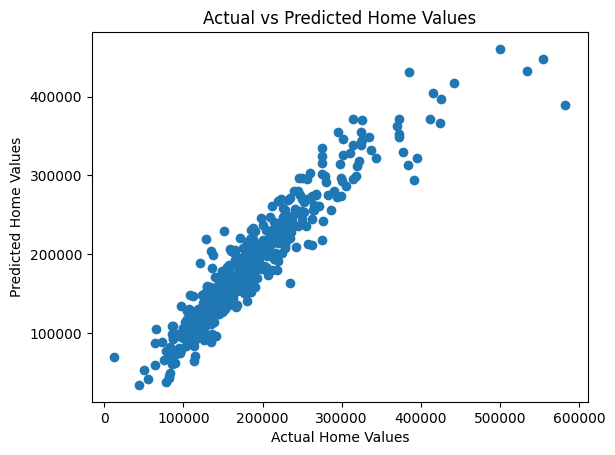

In [91]:
plt.scatter(y_comb_test, y_comb_predict);
plt.xlabel('Actual Home Values')
plt.ylabel('Predicted Home Values')
plt.title('Actual vs Predicted Home Values')

In [92]:
lr_comb.intercept_

-101017.59627863896

In [93]:
print(lr_comb.coef_.shape)
lr_comb.coef_

(92,)


array([ 7.62095540e-01,  9.42977046e+03,  2.22837769e+01,  1.13871463e+04,
        3.06229116e+03,  5.67197224e+03, -8.86518413e+02,  1.21148043e+01,
        1.09427409e+01,  2.30236998e+03, -6.82128030e-01,  5.73230132e+01,
       -2.73786406e+03,  8.83963530e+03, -1.85844735e+03,  3.95996330e+03,
        1.48644968e+02,  2.21912745e+03,  1.03640200e+03,  2.62870472e+01,
        2.98973366e+01,  1.09154636e+01, -2.30635285e+02, -1.51765200e+02,
        1.43109474e+01, -6.06826962e+03,  2.90574514e+03,  2.55945421e+04,
        4.83959747e+04,  2.27354143e+04,  1.32505839e+04,  1.33810760e+04,
        4.31142923e+03,  1.43810955e+04, -6.54521817e+03, -1.74329515e+04,
       -2.14423086e+04,  8.20700285e+03, -1.55734719e+04, -1.76865829e+04,
       -1.25454083e+04,  1.07960760e+05, -1.50719672e+04,  5.62214650e+03,
        1.56085607e+04, -1.42064819e+04, -1.11031096e+04,  2.66654103e+04,
       -1.86564102e+04,  3.92223086e+03,  2.30302514e+04, -1.39608746e+04,
       -1.70785075e+04, -

In [94]:
print(X_comb.columns.shape)
X_comb.columns

(92,)


Index(['lot_area', 'overall_qual', 'mas_vnr_area', 'exter_qual', 'bsmt_qual',
       'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1', 'total_bsmt_sf',
       'heating_qc', '1st_flr_sf', 'gr_liv_area', 'full_bath', 'kitchen_qual',
       'totrms_abvgrd', 'fireplaces', 'fireplace_qu', 'garage_finish',
       'garage_cars', 'garage_area', 'wood_deck_sf', 'open_porch_sf',
       'age_at_sale', 'age_since_remod', 'bsmnt_fin_sf', 'has_wood_deck',
       'ms_zoning_C (all)', 'ms_zoning_FV', 'ms_zoning_I (all)',
       'ms_zoning_RH', 'ms_zoning_RL', 'ms_zoning_RM', 'neighborhood_Blueste',
       'neighborhood_BrDale', 'neighborhood_BrkSide', 'neighborhood_ClearCr',
       'neighborhood_CollgCr', 'neighborhood_Crawfor', 'neighborhood_Edwards',
       'neighborhood_Gilbert', 'neighborhood_Greens', 'neighborhood_GrnHill',
       'neighborhood_IDOTRR', 'neighborhood_Landmrk', 'neighborhood_MeadowV',
       'neighborhood_Mitchel', 'neighborhood_NAmes', 'neighborhood_NPkVill',
       'neighborhoo

In [95]:
pd.DataFrame(data = lr_comb.coef_, 
             index = X_comb.columns, 
             columns = ['Coefficients']).sort_values('Coefficients', ascending = False)

,Coefficients
neighborhood_GrnHill,"107,960.8"
ms_zoning_I (all),"48,396.0"
neighborhood_StoneBr,"39,645.5"
neighborhood_NPkVill,"26,665.4"
foundation_Slab,"26,212.3"
ms_zoning_FV,"25,594.5"
garage_type_None,"23,221.9"
neighborhood_NridgHt,"23,030.3"
ms_zoning_RH,"22,735.4"
neighborhood_MeadowV,"15,608.6"


### Ridge & Lasso Models

In [96]:
#Using a standard scale with Ridge

In [97]:
sc_comb = StandardScaler()

In [98]:
X_comb_train.head(5)

,lot_area,overall_qual,mas_vnr_area,exter_qual,bsmt_qual,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,total_bsmt_sf,heating_qc,...,mo_sold_11,mo_sold_12,mo_sold_2,mo_sold_3,mo_sold_4,mo_sold_5,mo_sold_6,mo_sold_7,mo_sold_8,mo_sold_9
640,3087,7,14.0,4,4,3,6,453.0,"1,220.0",5,...,1,0,0,0,0,0,0,0,0,0
1946,11070,7,70.0,3,3,1,1,0.0,"1,907.0",4,...,0,0,0,0,0,0,0,1,0,0
877,12122,7,210.0,5,3,3,5,867.0,944.0,4,...,0,0,0,0,0,0,0,1,0,0
988,11143,8,0.0,4,4,1,1,0.0,"1,580.0",5,...,0,1,0,0,0,0,0,0,0,0
1943,7500,4,0.0,3,3,1,1,0.0,698.0,3,...,0,0,0,0,1,0,0,0,0,0


In [99]:
Z_comb_train = sc_comb.fit_transform(X_comb_train)
Z_comb_test = sc_comb.fit_transform(X_comb_test)

In [100]:
Z_comb_train.shape, Z_comb_test.shape, y_comb_train.shape, y_comb_test.shape

((1536, 92), (513, 92), (1536,), (513,))

In [101]:
Z_comb_train

array([[-1.06865309,  0.6078506 , -0.48470663, ..., -0.42607331,
        -0.29504039, -0.24353715],
       [ 0.17390429,  0.6078506 , -0.16683374, ...,  2.34701397,
        -0.29504039, -0.24353715],
       [ 0.33764855,  0.6078506 ,  0.62784846, ...,  2.34701397,
        -0.29504039, -0.24353715],
       ...,
       [-0.23389983, -0.78775258, -0.56417485, ...,  2.34701397,
        -0.29504039, -0.24353715],
       [-0.54753545, -0.08995099, -0.56417485, ..., -0.42607331,
        -0.29504039, -0.24353715],
       [-0.93417112,  2.70125538, -0.56417485, ..., -0.42607331,
        -0.29504039, -0.24353715]])

In [102]:
ols = LinearRegression()

In [103]:
ols.fit(Z_comb_train, y_comb_train)

LinearRegression()

In [104]:
print ( ols.score(Z_comb_train, y_comb_train) )
print ( ols.score(Z_comb_test, y_comb_test) )

0.9129396877125386
0.8811552994754956


In [105]:
ridge = Ridge()

ridge.fit(Z_comb_train, y_comb_train)

Ridge()

In [106]:
print(f'Training Score: {ridge.score(Z_comb_train, y_comb_train)}')
print(f'Testing Score: {ridge.score(Z_comb_test, y_comb_test)}')

Training Score: 0.9129358903007179
Testing Score: 0.8815136149295131


In [107]:
alphas = np.logspace(0, 5, 100)
ridge_cv = RidgeCV(alphas = alphas, cv = 5)
ridge_cv.fit(Z_comb_train, y_comb_train)

RidgeCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+0...
       6.89261210e+03, 7.74263683e+03, 8.69749003e+03, 9.77009957e+03,
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]),
        cv=5)

In [108]:
#This is the optimal value of alpha
ridge_cv.alpha_

52.14008287999685

In [109]:
ridge_cv.best_score_

0.8941477972201133

In [110]:
print(f'Training score with ridge cv: {ridge_cv.score(Z_comb_train, y_comb_train)}')
print(f'Testing score with ridge cv: {ridge_cv.score(Z_comb_test, y_comb_test)}')

Training score with ridge cv: 0.9117308254020378
Testing score with ridge cv: 0.8864752044632623


In [111]:
cross_val_score(ridge_cv, Z_comb_train, y_comb_train).mean()

0.8939592543586118

In [125]:
y_ridge_predict = lr_comb.predict(Z_comb_test)
ridge_rmse = metrics.mean_squared_error(y_comb_test, y_ridge_predict, squared = False)
ridge_rmse

C:\Users\david\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


292554.4781328812

#### Lasso Regression

In [112]:
#Set up list of Lasso alphas to check
l_alphas = np.logspace(-3, 0, 100)

In [113]:
#Cross validate over our list of Lasso alphas
lasso_cv = LassoCV(alphas = l_alphas)

In [114]:
#Fit model using the mest ridge alpha
lasso_cv.fit(Z_comb_train, y_comb_train)

C:\Users\david\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22410360434.413696, tolerance: 797989355.6090754
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\david\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28572490989.667664, tolerance: 757883217.1574593
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\david\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19310857434.084656, tolerance: 798600289.5218645
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\david\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617:

LassoCV(alphas=array([0.001     , 0.00107227, 0.00114976, 0.00123285, 0.00132194,
       0.00141747, 0.00151991, 0.00162975, 0.00174753, 0.00187382,
       0.00200923, 0.00215443, 0.00231013, 0.00247708, 0.00265609,
       0.00284804, 0.00305386, 0.00327455, 0.00351119, 0.00376494,
       0.00403702, 0.00432876, 0.00464159, 0.00497702, 0.0053367 ,
       0.00572237, 0.00613591, 0.00657933, 0.0070548 , 0.00756463,
       0.008...
       0.09326033, 0.1       , 0.10722672, 0.1149757 , 0.12328467,
       0.13219411, 0.14174742, 0.15199111, 0.16297508, 0.17475284,
       0.18738174, 0.2009233 , 0.21544347, 0.23101297, 0.24770764,
       0.26560878, 0.28480359, 0.30538555, 0.32745492, 0.35111917,
       0.37649358, 0.40370173, 0.43287613, 0.46415888, 0.49770236,
       0.53366992, 0.57223677, 0.61359073, 0.65793322, 0.70548023,
       0.75646333, 0.81113083, 0.869749  , 0.93260335, 1.        ]))

In [115]:
#Optimal value of alpha is
lasso_cv.alpha_

1.0

In [116]:
print(lasso_cv.score(Z_comb_train, y_comb_train))
print(lasso_cv.score(Z_comb_test, y_comb_test))

0.912938929101649
0.8812798712092869


In [117]:
cross_val_score(lasso_cv, Z_comb_train, y_comb_train).mean()

C:\Users\david\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3747019494.5543213, tolerance: 632061717.3026392
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\david\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10230615489.497498, tolerance: 592874292.8199463
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\david\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6221838636.892456, tolerance: 655041417.604792
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\david\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: C

0.8927669918201225

In [118]:
lasso_coefs = lasso_cv.coef_

In [119]:
#Create a list of (features, coefficients) tuples
coef_tuples = list(zip(X_comb_train.columns, lasso_coefs))

#sort the coefficients based on the absolute value (in descending order)
sorted_coefs = sorted(coef_tuples, key = lambda x: -abs(x[1]))

for feature, coef in sorted_coefs:
    print(f"{feature}: {coef:.4f}")

gr_liv_area: 28547.6596
overall_qual: 13524.8009
bldg_type_TwnhsE: -9027.0269
age_at_sale: -6978.8265
bldg_type_Twnhs: -6975.7047
exter_qual: 6692.3158
bsmnt_fin_sf: 6627.4299
garage_type_Detchd: 6374.0238
bsmt_exposure: 6192.5091
neighborhood_CollgCr: -5988.4825
kitchen_qual: 5930.4650
garage_area: 5644.7159
neighborhood_StoneBr: 5608.5871
neighborhood_NridgHt: 5497.0195
bsmtfin_sf_1: 5332.5720
garage_type_None: 5278.4988
ms_zoning_FV: 4969.5572
lot_area: 4893.6726
garage_type_Attchd: 4762.0653
total_bsmt_sf: 4607.0340
neighborhood_SawyerW: -4590.6821
ms_zoning_RL: 4469.1599
neighborhood_Edwards: -3983.6242
ms_zoning_RM: 3958.8904
mas_vnr_area: 3924.6268
neighborhood_GrnHill: 3899.6602
neighborhood_NAmes: -3849.7169
neighborhood_Gilbert: -3819.4462
wood_deck_sf: 3767.6232
neighborhood_OldTown: -3719.0655
neighborhood_NWAmes: -3582.9454
foundation_Slab: 3232.8852
age_since_remod: -3178.5176
house_style_1Story: 3106.0108
garage_type_BuiltIn: 3090.0648
has_wood_deck: -3024.3402
totrms_ab

In [126]:
y_lasso_predict = lr_comb.predict(Z_comb_test)
lasso_rmse = metrics.mean_squared_error(y_comb_test, y_lasso_predict, squared = False)
lasso_rmse

C:\Users\david\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


292554.4781328812

In [120]:
### The only variable the Lasso is zeroing out is being in the Industrial Zone. But doesn't make sense to zero out just one category in a categorical variable.

#### Polynomial Features on Numeric Data

In [188]:
X_numeric.head(5)

,ms_subclass,lot_frontage,lot_area,lot_shape,land_slope,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,...,pool_area,fence,misc_val,yr_sold,age_at_sale,age_since_remod,bsmnt_fin_sf,sold_in_crisis,has_wood_deck,has_pool
0,60,0.0,13517,3,3,6,8,1976,2005,289.0,...,0,0,0,2010,34,5,533.0,1,0,0
1,60,43.0,11492,3,3,7,5,1996,1997,132.0,...,0,0,0,2009,13,12,637.0,1,0,0
2,20,68.0,7922,4,3,5,7,1953,2007,0.0,...,0,0,0,2010,57,3,731.0,1,0,0
3,60,73.0,9802,4,3,5,5,2006,2007,0.0,...,0,0,0,2010,4,3,0.0,1,1,0
4,50,82.0,14235,3,3,6,8,1900,1993,0.0,...,0,0,0,2010,110,17,0.0,1,0,0


In [190]:
poly = PolynomialFeatures(degree = 2, interaction_only = False, include_bias = False)

X_numeric_overfit = poly.fit_transform(X_numeric)

In [191]:
X_numeric_overfit.shape

(2049, 1890)

In [192]:
poly.get_feature_names_out(X_numeric.columns)

array(['ms_subclass', 'lot_frontage', 'lot_area', ..., 'has_wood_deck^2',
       'has_wood_deck has_pool', 'has_pool^2'], dtype=object)

In [193]:
X_overfit_train, X_overfit_test, y_overfit_train, y_overfit_test = train_test_split(X_numeric_overfit,
                                                                                    y)

In [194]:
X_overfit_train.shape, X_overfit_test.shape, y_overfit_train.shape, y_overfit_test.shape

((1536, 1890), (513, 1890), (1536,), (513,))

In [195]:
sc = StandardScaler()

Z_overfit_train = sc.fit_transform(X_overfit_train)
Z_overfit_test = sc.fit_transform(X_overfit_test)

In [197]:
ols_overfit = LinearRegression()
ols_overfit.fit(Z_overfit_train, y_overfit_train)

LinearRegression()

In [199]:
print(f'Training Score: {ols_overfit.score(Z_overfit_train, y_overfit_train)}')
print(f'Testing Score: {ols_overfit.score(Z_overfit_test, y_overfit_test)}')

Training Score: 0.9968929645317259
Testing Score: -1.1775620085943792e+17


In [200]:
#### All these features train the model well, but overfit

In [209]:
#Instantiate Ridge
ridge = Ridge()

#Set up list of ridge alphas to check
alphas = np.logspace(0, 5, 100)

ridge_overfit_cv = RidgeCV(alphas = alphas, cv = 5)

ridge_overfit_cv.fit(Z_overfit_train, y_overfit_train)


RidgeCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+0...
       6.89261210e+03, 7.74263683e+03, 8.69749003e+03, 9.77009957e+03,
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]),
        cv=5)

In [210]:
ridge_overfit_cv.alpha_

533.6699231206308

In [211]:
ridge_overfit_cv.best_score_

0.9215515512449899

In [214]:
print(f'Training Score with ridge cv: {ridge_overfit_cv.score(Z_overfit_train, y_overfit_train)}')
print(f'Training Score with ridge cv: {ridge_overfit_cv.score(Z_overfit_test, y_overfit_test)}')


Training Score with ridge cv: 0.9521611332561488
Training Score with ridge cv: 0.9242638367577477


#### Lasso on Polynomial Features -- Takes too long to run, ignore

In [218]:
 
# l_alphas = np.logspace(-3, 0, 100)

# lasso_overfit_cv = LassoCV(alphas = l_alphas)

# lasso_overfit_cv.fit(Z_overfit_train, y_overfit_train)

C:\Users\david\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.316e+10, tolerance: 8.099e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\david\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.710e+10, tolerance: 8.099e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\david\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.421e+10, toleranc

LassoCV(alphas=array([0.001     , 0.00107227, 0.00114976, 0.00123285, 0.00132194,
       0.00141747, 0.00151991, 0.00162975, 0.00174753, 0.00187382,
       0.00200923, 0.00215443, 0.00231013, 0.00247708, 0.00265609,
       0.00284804, 0.00305386, 0.00327455, 0.00351119, 0.00376494,
       0.00403702, 0.00432876, 0.00464159, 0.00497702, 0.0053367 ,
       0.00572237, 0.00613591, 0.00657933, 0.0070548 , 0.00756463,
       0.008...
       0.09326033, 0.1       , 0.10722672, 0.1149757 , 0.12328467,
       0.13219411, 0.14174742, 0.15199111, 0.16297508, 0.17475284,
       0.18738174, 0.2009233 , 0.21544347, 0.23101297, 0.24770764,
       0.26560878, 0.28480359, 0.30538555, 0.32745492, 0.35111917,
       0.37649358, 0.40370173, 0.43287613, 0.46415888, 0.49770236,
       0.53366992, 0.57223677, 0.61359073, 0.65793322, 0.70548023,
       0.75646333, 0.81113083, 0.869749  , 0.93260335, 1.        ]))

In [220]:
lasso_cv.alpha_

1.0

#### Combine All Numeric Features and Some Categorical Features

In [228]:
all_numeric_some_cat = df[numeric_data_cols + fewer_cat_col_name]
all_numeric_some_cat.head()
all_numeric_some_cat.isnull().sum()

id                   0
pid                  0
ms_subclass          0
lot_frontage         0
lot_area             0
lot_shape            0
land_slope           0
overall_qual         0
overall_cond         0
year_built           0
year_remod/add       0
mas_vnr_area         0
exter_qual           0
exter_cond           0
bsmt_qual            0
bsmt_cond            0
bsmt_exposure        0
bsmtfin_type_1       0
bsmtfin_sf_1         0
bsmtfin_type_2       0
bsmtfin_sf_2         0
bsmt_unf_sf          0
total_bsmt_sf        0
heating_qc           0
central_air          0
electrical           0
1st_flr_sf           0
2nd_flr_sf           0
low_qual_fin_sf      0
gr_liv_area          0
bsmt_full_bath       0
bsmt_half_bath       0
full_bath            0
half_bath            0
bedroom_abvgr        0
kitchen_abvgr        0
kitchen_qual         0
totrms_abvgrd        0
functional           0
fireplaces           0
fireplace_qu         0
garage_yr_blt      114
garage_finish        0
garage_cars

In [230]:
drop_cols = ['garage_yr_blt', 'id', 'pid', 'saleprice']
filtered_df = all_numeric_some_cat.drop(columns = drop_cols)
filtered_df.head()

,ms_subclass,lot_frontage,lot_area,lot_shape,land_slope,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,...,sold_in_crisis,has_wood_deck,has_pool,ms_zoning,neighborhood,bldg_type,house_style,foundation,garage_type,mo_sold
0,60,0.0,13517,3,3,6,8,1976,2005,289.0,...,1,0,0,RL,Sawyer,1Fam,2Story,CBlock,Attchd,3
1,60,43.0,11492,3,3,7,5,1996,1997,132.0,...,1,0,0,RL,SawyerW,1Fam,2Story,PConc,Attchd,4
2,20,68.0,7922,4,3,5,7,1953,2007,0.0,...,1,0,0,RL,NAmes,1Fam,1Story,CBlock,Detchd,1
3,60,73.0,9802,4,3,5,5,2006,2007,0.0,...,1,1,0,RL,Timber,1Fam,2Story,PConc,BuiltIn,4
4,50,82.0,14235,3,3,6,8,1900,1993,0.0,...,1,0,0,RL,SawyerW,1Fam,1.5Fin,PConc,Detchd,3


In [231]:
filtered_dums = pd.get_dummies(filtered_df, dtype = int, 
                         sparse = False, 
                         drop_first = True)
filtered_dums.head()

,ms_subclass,lot_frontage,lot_area,lot_shape,land_slope,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,...,mo_sold_11,mo_sold_12,mo_sold_2,mo_sold_3,mo_sold_4,mo_sold_5,mo_sold_6,mo_sold_7,mo_sold_8,mo_sold_9
0,60,0.0,13517,3,3,6,8,1976,2005,289.0,...,0,0,0,1,0,0,0,0,0,0
1,60,43.0,11492,3,3,7,5,1996,1997,132.0,...,0,0,0,0,1,0,0,0,0,0
2,20,68.0,7922,4,3,5,7,1953,2007,0.0,...,0,0,0,0,0,0,0,0,0,0
3,60,73.0,9802,4,3,5,5,2006,2007,0.0,...,0,0,0,0,1,0,0,0,0,0
4,50,82.0,14235,3,3,6,8,1900,1993,0.0,...,0,0,0,1,0,0,0,0,0,0


In [232]:
filtered_dums.isnull().sum()

ms_subclass             0
lot_frontage            0
lot_area                0
lot_shape               0
land_slope              0
overall_qual            0
overall_cond            0
year_built              0
year_remod/add          0
mas_vnr_area            0
exter_qual              0
exter_cond              0
bsmt_qual               0
bsmt_cond               0
bsmt_exposure           0
bsmtfin_type_1          0
bsmtfin_sf_1            0
bsmtfin_type_2          0
bsmtfin_sf_2            0
bsmt_unf_sf             0
total_bsmt_sf           0
heating_qc              0
central_air             0
electrical              0
1st_flr_sf              0
2nd_flr_sf              0
low_qual_fin_sf         0
gr_liv_area             0
bsmt_full_bath          0
bsmt_half_bath          0
full_bath               0
half_bath               0
bedroom_abvgr           0
kitchen_abvgr           0
kitchen_qual            0
totrms_abvgrd           0
functional              0
fireplaces              0
fireplace_qu

In [253]:
cols_used_in_model = filtered_dums.columns.tolist


method

In [234]:
X_filt_num_cat = filtered_dums
y_filt_num_cat = df['saleprice']

In [235]:
X_filt_num_cat_train, X_filt_num_cat_test, y_filt_num_cat_train, y_filt_num_cat_test = train_test_split(X_filt_num_cat, y)

In [236]:
X_filt_num_cat_train.shape, X_filt_num_cat_test.shape, y_filt_num_cat_train.shape, y_filt_num_cat_test.shape

((1536, 126), (513, 126), (1536,), (513,))

In [237]:
lr_filt_num_cat = LinearRegression()

In [239]:
lr_filt_num_cat.fit(X_filt_num_cat_train, y_filt_num_cat_train)

LinearRegression()

In [241]:
lr_filt_num_cat.score(X_filt_num_cat_train, y_filt_num_cat_train)

0.9212418626549606

In [242]:
lr_filt_num_cat.score(X_filt_num_cat_test, y_filt_num_cat_test)

0.8993536876044197

In [244]:
cross_val_score(lr_filt_num_cat, X_filt_num_cat_train, y_filt_num_cat_train).mean()

0.8962837024142288

In [245]:
y_filt_num_cat_preds = lr_filt_num_cat.predict(X_filt_num_cat_test)

In [247]:
filt_num_cat_rmse = metrics.mean_squared_error(y_filt_num_cat_test, y_filt_num_cat_preds, squared = False)
filt_num_cat_rmse

25347.224289284422

#### Using Standard Scaler on Combined Data

In [260]:
ss = StandardScaler()

In [262]:
Z_filt_num_cat_train_scale = ss.fit_transform(X_filt_num_cat_train)
Z_filt_num_cat_test_scale = ss.transform(X_filt_num_cat_test)

In [263]:
ols = LinearRegression()
ols.fit(Z_filt_num_cat_train_scale, y_filt_num_cat_train)

LinearRegression()

In [264]:
print(f'Training Score: {ols.score(Z_filt_num_cat_train_scale, y_filt_num_cat_train)}')
print(f'Testing Score: {ols.score(Z_filt_num_cat_test_scale, y_filt_num_cat_test)}')

Training Score: 0.9212452426741581
Testing Score: 0.899421879303092


In [268]:
y_filt_num_cat_preds = ols.predict(Z_filt_num_cat_test_scale)

In [269]:
rmse_filt_num_ridge = metrics.mean_squared_error(y_filt_num_cat_test, y_filt_num_cat_preds, squared = False)
rmse_filt_num_ridge

25338.635980805673